CSV guardado en: simulacion_decaimientos_events.csv
Figura guardada: hist_M_reco_all.png
Figura guardada: hist_M_reco_by_proc.png
Figura guardada: armenteros_all.png
Figura guardada: armenteros_by_proc.png
Conteos en ventanas alrededor de picos:
  K0 (~497.6 MeV) ±20 MeV: 7848
  Lambda (~1115.7 MeV) ±25 MeV: 14686
Total eventos: 30000 (K0 verdaderos: 7452, Lambda verdaderos: 7549)
Simulación completada.


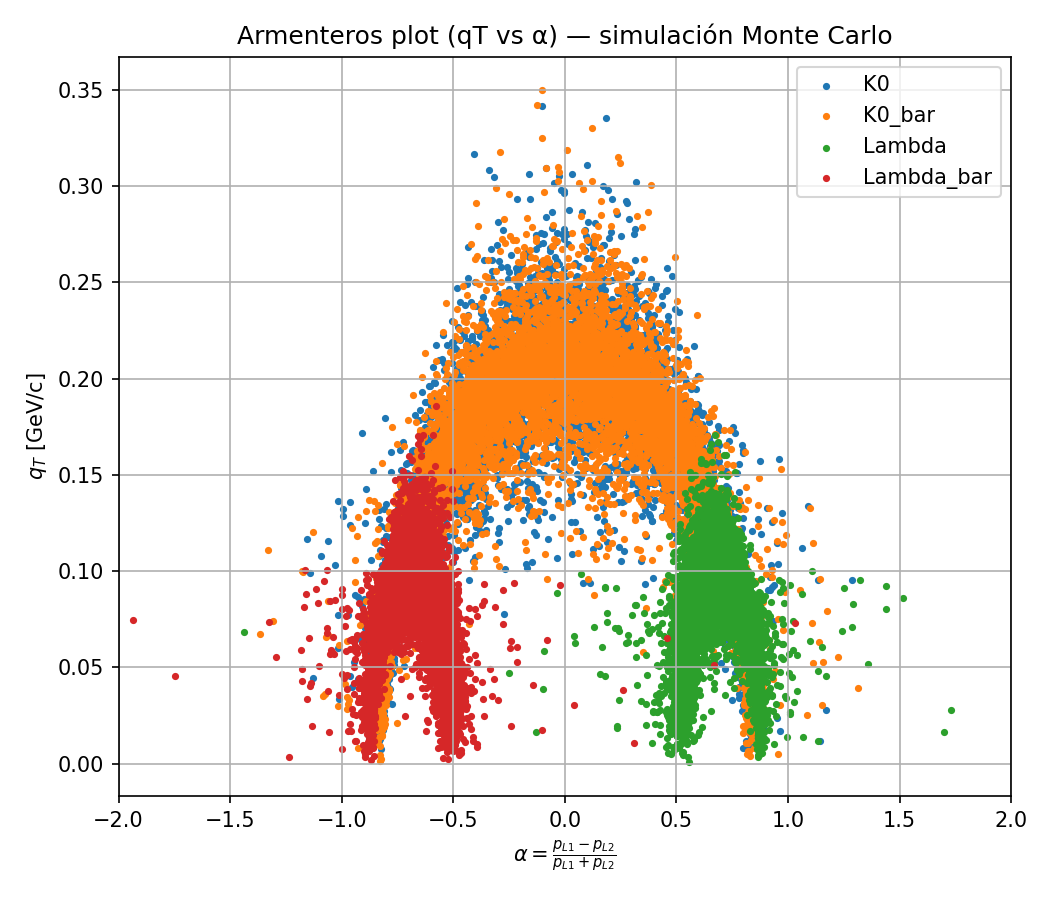

In [8]:
"""
Simulación Monte Carlo de decaimientos de partículas extrañas:
    K0  → π⁺ π⁻
    Λ0  → p π⁻
y sus antipartículas correspondientes.

La simulación:
 - Reconstruye la masa invariante a partir de los productos del decaimiento.
 - Calcula el Armenteros plot (qT vs α).
 - Aplica un “smear” (difuminado) simple para simular la resolución del detector.
 - Guarda resultados en un CSV.
 - Genera gráficos PNG con histogramas y diagramas de dispersión.

Requisitos:
    numpy, pandas, matplotlib, os
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


# ============================================================
# 1. Constantes físicas (en MeV, usando c = 1)
# ============================================================
m_pi = 139.570      # masa del pión
m_p  = 938.272      # masa del protón
m_K0 = 497.611      # masa del K0 (neutral)
m_L  = 1115.683     # masa del Lambda0


# ============================================================
# 2. Funciones auxiliares de física
# ============================================================

def energy_to_p(E, m):
    """Dada energía total E y masa m, devuelve el módulo del momento p (MeV)."""
    p2 = E**2 - m**2
    return np.sqrt(np.maximum(p2, 0.0))  # Evita valores negativos por redondeo


def two_body_decay_momenta(M, m1, m2):
    """
    Cinemática de decaimiento de dos cuerpos en el sistema en reposo.
    M -> m1 + m2
    Retorna (E1, p1, E2, p2), donde p1 = p2 = |p|.
    """
    E1 = (M**2 + m1**2 - m2**2) / (2.0*M)
    E2 = (M**2 + m2**2 - m1**2) / (2.0*M)
    p1 = energy_to_p(E1, m1)
    p2 = energy_to_p(E2, m2)
    return E1, p1, E2, p2


def random_direction():
    """
    Devuelve un vector unitario isotrópico (dirección aleatoria en 3D)
    junto con los ángulos esféricos (theta, phi).
    """
    cos_theta = 2.0*np.random.rand() - 1.0
    theta = np.arccos(cos_theta)
    phi = 2.0*np.pi*np.random.rand()
    ux = np.sin(theta)*np.cos(phi)
    uy = np.sin(theta)*np.sin(phi)
    uz = cos_theta
    return np.array([ux, uy, uz]), theta, phi


def lorentz_boost(p4, beta_vec):
    """
    Aplica un boost de Lorentz unidimensional (en el eje x)
    al 4-vector p4 = (E, px, py, pz), con velocidad beta_vec = (beta, 0, 0).
    Transforma desde el sistema en reposo al sistema laboratorio.
    """
    beta = np.linalg.norm(beta_vec)
    if beta == 0:
        return p4.copy()

    gamma = 1.0 / np.sqrt(1.0 - beta**2)
    E, px, py, pz = p4
    beta_x = beta_vec[0]

    # Transformación en eje x (según la matriz del PDF)
    E_prime  = gamma * (E + beta_x * px)
    px_prime = gamma * (px + beta_x * E)
    py_prime = py
    pz_prime = pz

    p_par = np.array([px_prime, py_prime, pz_prime])
    return np.concatenate(([E_prime], p_par))


# ============================================================
# 3. Smearing (simula la resolución del detector)
# ============================================================

def smear_vector(vec, frac_p=0.05, smear_angle=0.01):
    """
    Aplica smear (ruido gaussiano) a la magnitud del momento y a los ángulos.
    frac_p: error relativo en la magnitud (por ejemplo 0.05 = 5%)
    smear_angle: error angular (radianes)
    """
    x, y, z = vec
    r = np.linalg.norm(vec)
    if r == 0:
        return vec.copy()

    # Magnitud con ruido
    p_obs = np.random.normal(r, frac_p * r)

    # Ángulos actuales
    theta = np.arccos(np.clip(z / r, -1.0, 1.0))
    phi = np.arctan2(y, x)

    # Ángulos con ruido
    theta_obs = np.random.normal(theta, smear_angle * max(1.0, theta))
    phi_obs = np.random.normal(phi, smear_angle * max(1.0, abs(phi)))

    # Reconstruir nuevo vector
    vx = p_obs * np.sin(theta_obs) * np.cos(phi_obs)
    vy = p_obs * np.sin(theta_obs) * np.sin(phi_obs)
    vz = p_obs * np.cos(theta_obs)

    return np.array([vx, vy, vz])


# ============================================================
# 4. Simulación principal de los decaimientos
# ============================================================

def simulate(N=30000, seed=42,
             E_min=600.0, E_max=10000.0,
             frac_p_smear=0.05, angle_smear=0.01,
             out_csv="simulacion_decaimientos_events.csv",
             save_plots=True, outdir="results"):
    """
    Ejecuta la simulación de Monte Carlo.

    Parámetros:
    ------------
    N : int
        Número de eventos a simular.
    E_min, E_max : float
        Energía total mínima y máxima de la partícula madre en laboratorio (MeV).
    frac_p_smear : float
        Fracción de error en la magnitud del momento.
    angle_smear : float
        Desviación estándar angular en radianes.
    out_csv : str
        Nombre del archivo de salida con los eventos.
    save_plots : bool
        Si True, guarda las figuras.
    outdir : str
        Carpeta donde se guardan los resultados.
    """

    np.random.seed(seed)  # semilla aleatoria fija para reproducibilidad
    events = []           # lista para almacenar resultados

    # ------------------------------------------------------------
    # Bucle principal: genera N eventos
    # ------------------------------------------------------------
    for i in range(N):

        #Selecciona el tipo de proceso aleatoriamente (25% cada uno)
        r = np.random.rand()
        if r < 0.25:
            proc = "K0"
            M = m_K0
            m1 = m_pi
            m2 = m_pi
        elif r < 0.5:
            proc = "K0_bar"
            M = m_K0
            m1 = m_pi
            m2 = m_pi
        elif r < 0.75:
            proc = "Lambda"
            M = m_L
            m1 = m_p
            m2 = m_pi
        else:
            proc = "Lambda_bar"
            M = m_L
            m1 = m_pi  # intercambio de masas → antipartículas
            m2 = m_p

        # Genera energía y dirección aleatoria de la madre en laboratorio
       # Genera energía de la madre en laboratorio (se mueve en eje x)
        E_lab = np.random.uniform(max(M * 1.001, E_min), E_max)
        p_lab_mag = energy_to_p(E_lab, M)
        uM = np.array([1.0, 0.0, 0.0])  # boost en eje x
        pM_lab = p_lab_mag * uM
        betaM = pM_lab / E_lab          # velocidad (c = 1)
        thetaM, phiM = 0.0, 0.0         # ángulos fijos (madre en eje x)


        # 3️⃣ Decaimiento en el sistema en reposo de la madre
        E1_rest, p1_rest_mag, E2_rest, p2_rest_mag = two_body_decay_momenta(M, m1, m2)

        # Dirección aleatoria del producto 1
        u1_rest, theta1_rest, phi1_rest = random_direction()
        p1_rest = p1_rest_mag * u1_rest
        p2_rest = -p1_rest  # momento opuesto

        p4_1_rest = np.concatenate(([E1_rest], p1_rest))
        p4_2_rest = np.concatenate(([E2_rest], p2_rest))

        # 4️⃣ Boost al laboratorio (transforma los 4-vectores)
        p4_1_lab = lorentz_boost(p4_1_rest, betaM)
        p4_2_lab = lorentz_boost(p4_2_rest, betaM)

        # 5️⃣ Aplica el smear (resolución detector)
        p1_obs = smear_vector(p4_1_lab[1:], frac_p=frac_p_smear, smear_angle=angle_smear)
        p2_obs = smear_vector(p4_2_lab[1:], frac_p=frac_p_smear, smear_angle=angle_smear)
        E1_obs = np.sqrt(np.sum(p1_obs**2) + m1**2)
        E2_obs = np.sqrt(np.sum(p2_obs**2) + m2**2)

        # 6️⃣ Reconstrucción de masa invariante
        E_tot_obs = E1_obs + E2_obs
        p_tot_obs = p1_obs + p2_obs
        M_reco = np.sqrt(max(E_tot_obs**2 - np.sum(p_tot_obs**2), 0.0))

        # 7️⃣ Variables del Armenteros plot
        p_tot = p_tot_obs
        p_tot_norm = np.linalg.norm(p_tot)
        if p_tot_norm < 1e-12:
            p_tot_dir = np.array([0.0, 0.0, 1.0])
        else:
            p_tot_dir = p_tot / p_tot_norm

        qT = np.linalg.norm(p1_obs - np.dot(p1_obs, p_tot_dir) * p_tot_dir)  # momento transversal
        pL1 = np.dot(p1_obs, p_tot_dir)  # componente longitudinal partícula 1
        pL2 = np.dot(p2_obs, p_tot_dir)  # componente longitudinal partícula 2
        alpha = (pL1 - pL2) / (pL1 + pL2 + 1e-12)  # parámetro de asimetría

        # 8️⃣ Guarda el evento en la lista
        events.append({
            "proc": proc,
            "M_true": M,
            "E_lab": E_lab,
            "p_lab_mag": p_lab_mag,
            "M_reco": M_reco,
            "qT": qT,
            "alpha": alpha,
            "p1_mag_obs": np.linalg.norm(p1_obs),
            "p2_mag_obs": np.linalg.norm(p2_obs),
            "thetaM": thetaM,
            "phiM": phiM
        })

    # ------------------------------------------------------------
    # 9️⃣ Convertir lista a DataFrame
    # ------------------------------------------------------------
    df = pd.DataFrame(events)

    # Crear carpeta de salida
    if save_plots and not os.path.exists(outdir):
        os.makedirs(outdir, exist_ok=True)

    # Guardar archivo CSV con los resultados
    df.to_csv(out_csv, index=False)
    print(f"CSV guardado en: {out_csv}")

    # ============================================================
    # 5. Generación de gráficos
    # ============================================================
    if save_plots:
        # Histograma de masas reconstruidas (todos los eventos)
        plt.figure(figsize=(8,5))
        plt.hist(df["M_reco"], bins=150, range=(100,1500))
        plt.title("Histograma de masa invariante reconstruida (M_reco)")
        plt.xlabel("M_reco [MeV]")
        plt.ylabel("Eventos")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, "hist_M_reco_all.png"), dpi=150)
        plt.close()
        print("Figura guardada: hist_M_reco_all.png")

        # Histogramas por proceso (K0 vs Lambda)
        plt.figure(figsize=(8,5))
        plt.hist(df[df.proc=="K0"]["M_reco"], bins=120, range=(200,800), alpha=0.7, label="K0 reco")
        plt.hist(df[df.proc=="Lambda"]["M_reco"], bins=120, range=(800,1300), alpha=0.7, label="Lambda reco")
        plt.title("Masa reconstruida por proceso (K0 vs Lambda)")
        plt.xlabel("M_reco [MeV]")
        plt.ylabel("Eventos")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, "hist_M_reco_by_proc.png"), dpi=150)
        plt.close()
        print("Figura guardada: hist_M_reco_by_proc.png")

        # Armenteros plot (todos los eventos)
        plt.figure(figsize=(7,6))
        plt.scatter(df["alpha"], df["qT"], s=6)
        plt.title("Armenteros plot (qT vs alpha) — eventos simulados")
        plt.xlabel("alpha")
        plt.ylabel("qT [MeV]")
        plt.grid(True)
        plt.xlim(-2, 2)  # extiende el eje x de -2 a 2
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, "armenteros_all.png"), dpi=150)
        plt.close()
        print("Figura guardada: armenteros_all.png")

        # Armenteros plot por proceso (incluye antipartículas)
        plt.figure(figsize=(7,6))
        mask_K0      = df.proc == "K0"
        mask_K0_bar  = df.proc == "K0_bar"
        mask_Lambda  = df.proc == "Lambda"
        mask_LambdaB = df.proc == "Lambda_bar"

        plt.scatter(df[mask_K0]["alpha"],      df[mask_K0]["qT"]/1000, s=6, label="K0")
        plt.scatter(df[mask_K0_bar]["alpha"],  df[mask_K0_bar]["qT"]/1000, s=6, label="K0_bar")
        plt.scatter(df[mask_Lambda]["alpha"],  df[mask_Lambda]["qT"]/1000, s=6, label="Lambda")
        plt.scatter(df[mask_LambdaB]["alpha"], df[mask_LambdaB]["qT"]/1000, s=6, label="Lambda_bar")

        plt.title("Armenteros plot (qT vs α) — simulación Monte Carlo")
        plt.xlabel(r"$\alpha = \frac{p_{L1}-p_{L2}}{p_{L1}+p_{L2}}$")
        plt.ylabel(r"$q_T$ [GeV/c]")
        plt.legend()
        plt.xlim(-2, 2)  # extiende el eje x de -2 a 2
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, "armenteros_by_proc.png"), dpi=150)
        plt.close()
        print("Figura guardada: armenteros_by_proc.png")

    # ============================================================
    # 6. Resumen de conteos cerca de las masas esperadas
    # ============================================================
    def count_peak(df, center, width):
        """Cuenta cuántos eventos caen dentro de ±width alrededor de la masa center."""
        return ((df["M_reco"] > center - width) & (df["M_reco"] < center + width)).sum()

    count_K0 = count_peak(df, m_K0, 20.0)
    count_L  = count_peak(df, m_L, 25.0)
    print("Conteos en ventanas alrededor de picos:")
    print(f"  K0 (~{m_K0:.1f} MeV) ±20 MeV: {count_K0}")
    print(f"  Lambda (~{m_L:.1f} MeV) ±25 MeV: {count_L}")
    print(f"Total eventos: {len(df)} (K0 verdaderos: {(df.proc=='K0').sum()}, Lambda verdaderos: {(df.proc=='Lambda').sum()})")

    return df


# ============================================================
# 7. Ejecución si se corre como script
# ============================================================
if __name__ == "__main__":
    df = simulate(N=30000,
                  seed=42,
                  E_min=600.0,
                  E_max=10000.0,
                  frac_p_smear=0.05,
                  angle_smear=0.01,
                  out_csv="simulacion_decaimientos_events.csv",
                  save_plots=True,
                  outdir="results")
    print("Simulación completada.")


# ============================================================
# 8. Mostrar figura final (solo útil si se usa en Jupyter/Colab)
# ============================================================
from IPython.display import Image
Image("results/armenteros_by_proc.png")
